# Project course ML in business:  "Puthon-flask-docker"
## Client

Content:

    1. Example request;
    2. Check test data;
    3. Check multi-requests
    4. Evaluate model

### 1. Example request

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# rest api
import requests
import urllib.request
import json 

# metrics
from sklearn.metrics import roc_auc_score, precision_recall_curve

In [2]:
# example text
data = ( 
    "Hello my friend. I love you!"
)

In [3]:
# request function
def send_json(x):
    comment_text = x[0] if isinstance(x, pd.Series) else x
    
    body = {
        'comment_text': comment_text if comment_text is not np.nan else '',
        }

    myurl = 'http://localhost:8181' + '/predict'
    headers = {'content-type': 'application/json; charset=utf-8'}
    response = requests.post(myurl, json=body, headers=headers)
    return response.json()['predictions']

In [4]:
# request with one string
response = send_json(data)
print('Predictions:\n', response)

Predictions:
 [0.0040578371694852105, 0.0004706438508573116, 0.0054720394251326476, 0.002235866222883407, 0.0030444604355813333, 0.011192087874915966]


Let's look at the bar plot:

In [5]:
X_test = pd.read_csv('csv/X_test.csv')
y_test = pd.read_csv('csv/y_test.csv')

In [6]:
def view_probs(y_true, y_preds): 
    color = ['red','blue','green','yellow','black','orange']
    plt.ylim(0, 1)
    plt.bar(y_true.columns, np.array(y_preds), color = color )
    plt.title('Probabilities')

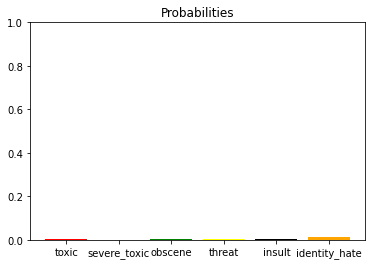

In [7]:
view_probs(y_test, response)

### 2. Check test data

In [8]:
a = pd.concat([X_test, y_test], axis=1)

In [9]:
a[a['toxic'] == 1].tail()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
39867,"Matt, when mattsanchez.info goes live on Monda...",1,0,0,0,0,0
39870,they are claiming that Gorbachev apologized th...,1,0,1,0,1,0
39877,"Hello, you Indian cannibal and child molester ...",1,0,0,0,1,1
39878,GAYWAD \n\nyou are a huge homo,1,0,0,0,1,1
39889,Fuck you!!!!!!!!!!!! \n\nand your foot,1,1,1,0,1,0


In [10]:
X_test.iloc[39870]['comment_text']

"they are claiming that Gorbachev apologized that accepted that Soviet crackdown on barbaric Baku was his the only and biggest mistake in his political life? Can you believe?? WHere are they taking this kind of information from? I guess they put their fingers in their rectum and get some information from there. My advice- just ignore that idiot named Grandmaster. Let him bullshit online if Wikipedia allows that. Paranoic people are all over. Azeri claims will never erase witnesses' memories. We are still alive"

In [11]:
response = send_json(X_test.iloc[39870])
print('Predictions:\n', response)

Predictions:
 [0.715985260861589, 0.001755533023083761, 0.12878847017252165, 0.001470190080993026, 0.08990023314200474, 0.0006556570467937011]


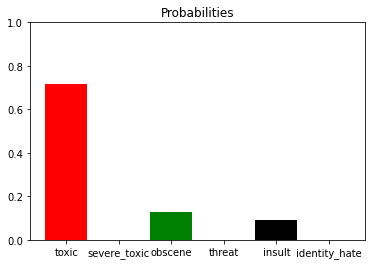

In [12]:
view_probs(y_test, response)

It's work. Good visibility.

### 3. Check multi-requests

In [13]:
N = 1000
start = 980

In [14]:
%%time
predictions = []
for i in range(start, start + N):
    predictions.append(send_json(X_test.iloc[i]))

CPU times: user 2.15 s, sys: 513 ms, total: 2.67 s
Wall time: 21.1 s


In [15]:
predictions[0]

[0.027287445379156915,
 0.002921102418095985,
 0.016987881580108343,
 0.0004357170087953383,
 0.014855194434695884,
 0.0009889857478431218]

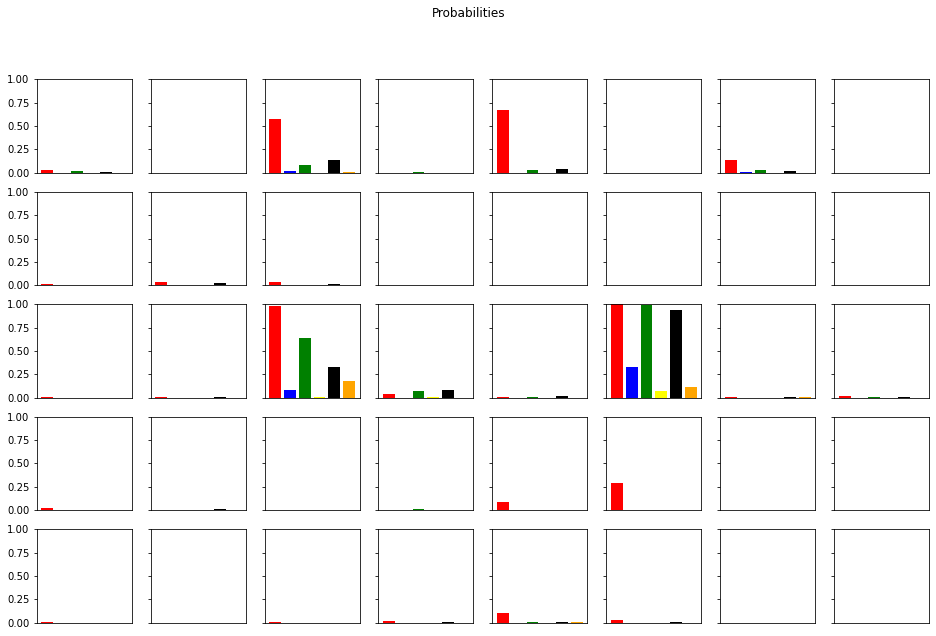

In [16]:
color = ['red','blue','green','yellow','black','orange']
ix = 0
rows = 5
cols = 8
fig, axs = plt.subplots(rows, cols, figsize=(16,10))
fig.suptitle('Probabilities')
for i in range(rows):
    for j in range(cols):
        axs[i, j].set_ylim(0, 1)
        axs[i, j].bar(y_test.columns, np.array(predictions[ix]), color = color )
        axs[i, j].axes.get_xaxis().set_visible(False)
        ix += 1

for ax in axs.flat:
    ax.label_outer()

### 4. Evaluate model

In [17]:
def evaluate_model(y_true, y_preds):
    # Precision Recall F-Score
    metrics_list = []
    ix_thresholds = []
    for i in range(y_true.shape[1]):
        t = y_true.iloc[:, i]
        p = y_preds.iloc[:, i]
        precision, recall, thresholds = precision_recall_curve(t, p)
        fscore = (2 * precision * recall) / (precision + recall)
        ix = np.argmax(fscore)
        metrics_list.append([thresholds, fscore, precision, recall])
        ix_thresholds.append(ix)
        print(f'Best Threshold for {y_test.columns[i]} = {thresholds[ix]}, \
        F-Score = {fscore[ix]:.3f}, Precision = {precision[ix]:.3f}, Recall = {recall[ix]:.3f}')
    
    # Mean F-Score
    fmean = []
    for i, m in zip(ix_thresholds, metrics_list):
        fmean.append(m[2][i])
    fscore_mean = np.mean(fmean)
    print(f'Mean F-Score = {fscore_mean}')
    
    # ROC AUC
    roc_auc = roc_auc_score(y_true, y_preds)
    print(f'ROC AUC = {roc_auc}')
    
    return fscore_mean, roc_auc

In [18]:
evaluate_model(y_test[start:(start + N)], pd.DataFrame(predictions))

Best Threshold for toxic = 0.396107321661904,         F-Score = 0.851, Precision = 0.895, Recall = 0.811
Best Threshold for severe_toxic = 0.15639632878024282,         F-Score = 0.593, Precision = 0.500, Recall = 0.727
Best Threshold for obscene = 0.504593518274631,         F-Score = 0.845, Precision = 0.911, Recall = 0.788
Best Threshold for threat = 0.18084220251733676,         F-Score = 0.800, Precision = 1.000, Recall = 0.667
Best Threshold for insult = 0.2087364187905626,         F-Score = 0.713, Precision = 0.679, Recall = 0.750
Best Threshold for identity_hate = 0.08263621376785017,         F-Score = 0.563, Precision = 0.450, Recall = 0.750
Mean F-Score = 0.7392842052232136
ROC AUC = 0.9862657737264694


(0.7392842052232136, 0.9862657737264694)

Server and model are working.